# Contents

### This project has 6 parts
### 1.Input and observe data


### 2.Data Processing
#### 1)Missing value processing

#### 2)Preliminary Feature Selection
##### a.Remove feature with zero variance
##### b.Drop useless columns

####  3)Dummy Variables

####  4)Create new variables
##### a.Calculate loan duration of each LID
##### b.Calculate revenue for each LID
##### c.Create boolean variables of whether loans are active for loan age 12,24,36,48,60
##### d.Create R(12),R(24),R(36),R(48),R(60)

####  5)Feature Insight


### 3.Model Construction


### 4.Use A1 to test models and select model¶

### 5. Predict p(12),p(24),p(36),p(48),p(60) and r(12),r(24),r(36),r(48),r(60) of A2


# Narrative

## 1)Observe Data
### At first, I input data to get some information about data's structure

## 2)Data Processing
### I spent my most time in this part. 
### First,
### I output the missing situation of each feature, Use different interpolation method for differnent situation
### a.Method:Delete rows
### Obeject:Missing rates are very small

### b.Method: mean-imputation
### Obeject: value is normal distributed, which is suitable for mean-imputation

### c.Method: median-imputation
### Object: value is skewed distributed,which is suitable for median-imputation

### d.Method: Delete columns
### Object: missing rates are too big

### Second,
### I removed feature which only has one value and features that are less correlated to our target

### Third,
### For categorical features,I transfer them to dummy variables which is suitable for creating model

### Fourth,
### In order to calculate p and r, I need to create targets for my model.So I create boolean variables of whether loans are active for loan age 12,24,36,48,60, using these boolean variables, we can create model and get p; For r, I create variables r(12),r(24),r(48),r(60).My idea is: if R=revenue untill m=loan's duration,for duration which is less than 12,r(12)=r(24)=r(36)=r(48)=(60)=R;for duration which is bigger than 12 and less than 24,r(12)=r(12),r(24)=r(36)=r(48)=(60)=R;for duration which is bigger than 24 and less than 36,r(12)=r(12),r(24)=r(24),r(36)=r(48)=(60)=R and so on

## 3)Model Construction
### For predicting p at 5 time points, I used the boolean features I created to construct several classification model:Logistic Regression, Decision Tree,Random Forest,KNN;For predicting r at 5 time points, I created regression model:Linear Regression,Decision Tree Regression,Lasso Regression,Random Forest Regression
### After using A1 to test model and comparing there performance, I choose optimal models for my 5 time points

## 4)Predicting A2

# Code

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1.Input and observe data
## (Including A0,A1,A2,CASH_FLOW0,CASH_FLOW1)

In [144]:
import pandas as pd

In [145]:
A0=pd.read_csv('A0.csv')

In [146]:
A0.shape

(156564, 26)

In [5]:
A0.head()

,LID,OCHANNEL,SELLER,INT_RATE,UPB,TERM,ORIG_DATE,FIRST_PMT_DATE,LTV,CLTV,...,NUNITS,OCC_STATUS,STATE,ZIP,MORT_INS_PCT,PROD_TYPE,CO_CREDIT_SCORE,MORT_INS_TYPE,REL_MORT_IND,group
0,899994927243,R,OTHER,8.000,125000.0,360.0,2000-11-01,2001-01-01,95.0,95.0,...,1,P,MI,492,30.0,FRM,NaN,1.0,N,0
1,899979172795,R,OTHER,7.125,214000.0,360.0,2001-01-01,2001-03-01,80.0,80.0,...,4,P,IL,604,NaN,FRM,NaN,NaN,N,0
2,899959222112,C,"CITIMORTGAGE, INC.",7.000,145000.0,360.0,2001-01-01,2001-03-01,71.0,71.0,...,1,P,CA,953,NaN,FRM,786.0,NaN,N,0
3,899958810652,R,FLEET NATIONAL BANK,7.875,150000.0,240.0,2000-10-01,2000-12-01,85.0,85.0,...,1,P,CO,810,6.0,FRM,NaN,1.0,N,0
4,899952449977,B,REGIONS BANK,6.750,123000.0,360.0,2001-01-01,2001-03-01,77.0,77.0,...,1,P,WA,982,NaN,FRM,756.0,NaN,N,0


In [147]:
CF0=pd.read_csv('CASH_FLOW0.csv')

In [148]:
CF0.shape

(5212923, 4)

In [149]:
CF0.head()

,LID,LOAN_AGE,PAYMENT,group
0,899994927243,0.0,0.000000,0
1,899994927243,1.0,917.205717,0
2,899994927243,2.0,917.205717,0
3,899994927243,3.0,917.205717,0
4,899994927243,4.0,917.205717,0


In [150]:
len(CF0['LID'].unique())

156564

# 2.Data Processing

In [159]:
# Set 'LID' as new index of each dataframe
A0a=A0.set_index(['LID'],inplace=False)

In [160]:
A0a.head()

,OCHANNEL,SELLER,INT_RATE,UPB,TERM,ORIG_DATE,FIRST_PMT_DATE,LTV,CLTV,NBORROWERS,...,NUNITS,OCC_STATUS,STATE,ZIP,MORT_INS_PCT,PROD_TYPE,CO_CREDIT_SCORE,MORT_INS_TYPE,REL_MORT_IND,group
LID,,,,,,,,,,,,,,,,,,,,,
899994927243,R,OTHER,8.000,125000.0,360.0,2000-11-01,2001-01-01,95.0,95.0,1.0,...,1,P,MI,492,30.0,FRM,NaN,1.0,N,0
899979172795,R,OTHER,7.125,214000.0,360.0,2001-01-01,2001-03-01,80.0,80.0,1.0,...,4,P,IL,604,NaN,FRM,NaN,NaN,N,0
899959222112,C,"CITIMORTGAGE, INC.",7.000,145000.0,360.0,2001-01-01,2001-03-01,71.0,71.0,2.0,...,1,P,CA,953,NaN,FRM,786.0,NaN,N,0
899958810652,R,FLEET NATIONAL BANK,7.875,150000.0,240.0,2000-10-01,2000-12-01,85.0,85.0,2.0,...,1,P,CO,810,6.0,FRM,NaN,1.0,N,0
899952449977,B,REGIONS BANK,6.750,123000.0,360.0,2001-01-01,2001-03-01,77.0,77.0,2.0,...,1,P,WA,982,NaN,FRM,756.0,NaN,N,0


## 1) Missing value processing 

In [161]:
#Calculate number of missing value
NANnum=[A0a.iloc[:,i].isna().sum() for i in range(25)]
NANnum=pd.DataFrame({'Feature Name':A0a.columns,"NAN number":NANnum})

NANnum

,Feature Name,NAN number
0,OCHANNEL,0
1,SELLER,0
2,INT_RATE,0
3,UPB,0
4,TERM,0
5,ORIG_DATE,0
6,FIRST_PMT_DATE,0
7,LTV,0
8,CLTV,23
9,NBORROWERS,171


## Get missing value number of each column
## Use different interpolation method for differnent situation
a.Variables: 'CLTV'and 'NBORROWERS'

  Method:Delete rows
  
  Reason:Missing rates of these two variables are very small
  
b.Variable: 'DTI'

  Method: mean-imputation
  
  Reason: DTI's value is normal distributed, which is suitable for mean-imputation
  
c.Variable: 'CREDIT_SCORE'

  Method: median-imputation
  
  Reason: CREDIT_SCORE's value is skewed distributed,which is suitable for median-imputation
  
d.Variables: 'MORT_INS_PCT', 'CO_CREDIT_SCORE' and 'MORT_INS_TYPE'

  Method: Delete rows
  
  Reason: Missing rates of these three variables are too big(MORT_INS_PCT:72.91%,CO_CREDIT_SCORE:52.57%,MORT_INS_TYPE:72.91%)

In [162]:
# drop rows of missing value of 'NBORROWERS'and 'DTI'(because the missing rate of these two variables are very small )
A0d=A0a[A0a['CLTV'].notna()]
A0e=A0d[A0d['NBORROWERS'].notna()]

In [163]:
A0e.shape

(156371, 25)

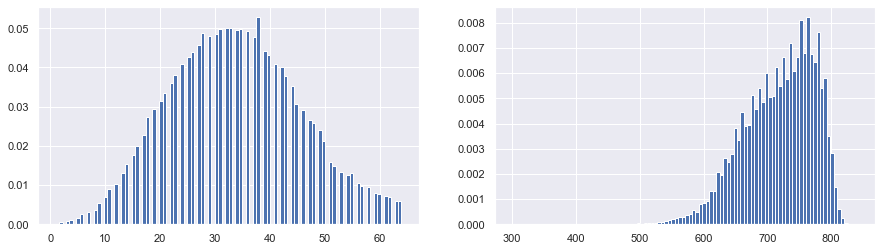

In [164]:
# impulate missing value of 'DTI' and 'CREDIT_SCORE'
import seaborn as sns
sns.set()
fig=plt.figure(figsize=(15,4))
ax1=fig.add_subplot(121)
A0e['DTI'].hist(bins=100,density=1)
ax2=fig.add_subplot(122)
A0e['CREDIT_SCORE'].hist(bins=100,density=1)

In [165]:
# normal distributed, suitable for mean impulation
A0e['DTI']=A0e['DTI'].fillna(A0e['DTI'].mean())

#skewed distributed, suitible for median imputation
A0e['CREDIT_SCORE']=A0e['CREDIT_SCORE'].fillna(A0e['CREDIT_SCORE'].median())

C:\Users\ROXHO\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\ROXHO\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [166]:
#NANnum=[A0e.iloc[:,i].isna().sum() for i in range(32)]
#NANnum=pd.DataFrame({'Feature Name':A0e.columns,"NAN number":NANnum})
#NANnum

In [167]:
# drop columns'FIRST_TIME_IND'and'CO_CREDIT_SCORE'and'MORT_INS_TYPE'

In [168]:
A0f=A0e.drop(['MORT_INS_PCT'],axis=1)
A0g=A0f.drop(['CO_CREDIT_SCORE'],axis=1)
A0h=A0g.drop(['MORT_INS_TYPE'],axis=1)

In [169]:
A0h.shape

(156371, 22)

In [170]:
A0h.head()

,OCHANNEL,SELLER,INT_RATE,UPB,TERM,ORIG_DATE,FIRST_PMT_DATE,LTV,CLTV,NBORROWERS,...,FIRST_TIME_IND,LOAN_PURPOSE,PROPERTY_TYPE,NUNITS,OCC_STATUS,STATE,ZIP,PROD_TYPE,REL_MORT_IND,group
LID,,,,,,,,,,,,,,,,,,,,,
899994927243,R,OTHER,8.000,125000.0,360.0,2000-11-01,2001-01-01,95.0,95.0,1.0,...,N,P,SF,1,P,MI,492,FRM,N,0
899979172795,R,OTHER,7.125,214000.0,360.0,2001-01-01,2001-03-01,80.0,80.0,1.0,...,N,P,SF,4,P,IL,604,FRM,N,0
899959222112,C,"CITIMORTGAGE, INC.",7.000,145000.0,360.0,2001-01-01,2001-03-01,71.0,71.0,2.0,...,N,P,SF,1,P,CA,953,FRM,N,0
899958810652,R,FLEET NATIONAL BANK,7.875,150000.0,240.0,2000-10-01,2000-12-01,85.0,85.0,2.0,...,N,C,SF,1,P,CO,810,FRM,N,0
899952449977,B,REGIONS BANK,6.750,123000.0,360.0,2001-01-01,2001-03-01,77.0,77.0,2.0,...,N,C,SF,1,P,WA,982,FRM,N,0


In [171]:
NANnum=[A0h.iloc[:,i].isna().sum() for i in range(22)]
NANnum=pd.DataFrame({'Feature Name':A0h.columns,"NAN number":NANnum})
NANnum
# Now there are no missing values in dataframe

,Feature Name,NAN number
0,OCHANNEL,0
1,SELLER,0
2,INT_RATE,0
3,UPB,0
4,TERM,0
5,ORIG_DATE,0
6,FIRST_PMT_DATE,0
7,LTV,0
8,CLTV,0
9,NBORROWERS,0


## 2) Preliminary Feature Selection

### a. Remove feature with zero variance

In [172]:
#Get all value of 'PROD_TYPE'
A0h['PROD_TYPE'].unique()

array(['FRM'], dtype=object)

In [173]:
#'PROD_TYPE'only has one value, so we drop this variable
A0i=A0h.drop(['PROD_TYPE'],axis=1)

### b.Drop useless columns

In [174]:
#Drop 'ORIG_DATE','FIRST_PMT_DATE','SELLER','ZIP','STATE' ,'OCHANNEL'and'group
A0j=A0i.drop(['ORIG_DATE'],axis=1)
A0j=A0j.drop(['FIRST_PMT_DATE'],axis=1)
A0j=A0j.drop(['SELLER'],axis=1)
A0j=A0j.drop(['ZIP'],axis=1)
A0j=A0j.drop(['STATE'],axis=1)
A0j=A0j.drop(['OCHANNEL'],axis=1)
A0j=A0j.drop(['group'],axis=1)

In [175]:
A0j.shape

(156371, 14)

## 3) Dummy Variables

### a.Get value of each character variable

In [32]:
A0j['FIRST_TIME_IND'].unique()

array(['N', 'Y', 'U'], dtype=object)

In [38]:
A0j['LOAN_PURPOSE'].unique()

array(['P', 'C', 'R', 'U'], dtype=object)

In [36]:
A0j['PROPERTY_TYPE'].unique()

array(['SF', 'CO', 'PU', 'CP', 'MH'], dtype=object)

In [37]:
A0j['NUNITS'].unique()

array([1, 4, 2, 3], dtype=int64)

In [39]:
A0j['OCC_STATUS'].unique()

array(['P', 'I', 'S'], dtype=object)

In [40]:
A0j['REL_MORT_IND'].unique()

array(['N', 'Y'], dtype=object)

### b. Get dummies

In [176]:
#Get dummies of each character variable and change their columns names
FIRST_TIME_IND_dummy=pd.get_dummies(A0j["FIRST_TIME_IND"],drop_first=True)
FIRST_TIME_IND_dummy.columns=['FTI(U)','FTI(Y)']

LOAN_PURPOSE_dummy=pd.get_dummies(A0j["LOAN_PURPOSE"],drop_first=True)
LOAN_PURPOSE_dummy.columns=['LP(P)','LP(R)','LP(U)']

PROPERTY_TYPE_dummy=pd.get_dummies(A0j["PROPERTY_TYPE"],drop_first=True)
PROPERTY_TYPE_dummy.columns=['PT(CP)','PT(MH)','PT(PU)','PT(SF)']

NUNITS_dummy=pd.get_dummies(A0j["NUNITS"],drop_first=True)
NUNITS_dummy.columns=['NUNITS(2)','NUNUTS(3)','NUNUTS(4)']

OCC_STATUS_dummy=pd.get_dummies(A0j["OCC_STATUS"],drop_first=True)
OCC_STATUS_dummy.columns=['OCC(P)','OCC(S)']

REL_MORT_IND_dummy=pd.get_dummies(A0j["REL_MORT_IND"],drop_first=True)
REL_MORT_IND_dummy.columns=['RMI(Y)']

In [177]:
#Merge dummies to original dataframe
A0k=A0j.merge(FIRST_TIME_IND_dummy,how='inner',left_on='LID',right_on='LID')
A0l=A0k.merge(LOAN_PURPOSE_dummy,how='inner',left_on='LID',right_on='LID')
A0m=A0l.merge(PROPERTY_TYPE_dummy,how='inner',left_on='LID',right_on='LID')
A0n=A0m.merge(NUNITS_dummy,how='inner',left_on='LID',right_on='LID')
A0o=A0n.merge(OCC_STATUS_dummy,how='inner',left_on='LID',right_on='LID')
A0p=A0o.merge(REL_MORT_IND_dummy,how='inner',left_on='LID',right_on='LID')

In [178]:
#Drop original columns of character variables
A0p=A0p.drop(['FIRST_TIME_IND'],axis=1)
A0p=A0p.drop(['LOAN_PURPOSE'],axis=1)
A0p=A0p.drop(['PROPERTY_TYPE'],axis=1)
A0p=A0p.drop(['NUNITS'],axis=1)
A0p=A0p.drop(['OCC_STATUS'],axis=1)
A0p=A0p.drop(['REL_MORT_IND'],axis=1)

In [179]:
A0p.shape

(156371, 23)

In [180]:
#A0p.to_csv('A0p.csv')

## 4) Create new variables

### a.Calculate loan duration of each LID

In [181]:
#Calculate loan duration of each LID
Payment_duration=pd.DataFrame(CF0['LID'].value_counts()-1)
Payment_duration.columns=['Duration']
Payment_duration['LID']=Payment_duration.index
Payment_duration.set_index(['LID'],inplace=True)
Payment_duration.head()

,Duration
LID,
320775941515,244
671874502331,244
516901455645,244
290175965954,244
93271506959,243


In [182]:
A0q=A0p.merge(Payment_duration,how='inner',left_on='LID',right_on='LID')

### b.Calculate revenue for each LID

In [183]:
#Calculate revenue for each LID
CF0a=pd.DataFrame(CF0.groupby('LID')['PAYMENT'].sum())
CF0a.columns=['Revenue']

In [184]:
A0r=A0q.merge(CF0a,how='inner',left_on='LID',right_on='LID')

### c.Create boolean variables of whether loans are active for loan age 12,24,36,48,60

In [185]:
# Create boolean variables of whether loans are active for loan age 12,24,36,48,60
P12=[A0r.iloc[i,23]>=12 for i in range(len(A0r))]
P24=[A0r.iloc[i,23]>=24 for i in range(len(A0r))]
P36=[A0r.iloc[i,23]>=36 for i in range(len(A0r))]
P48=[A0r.iloc[i,23]>=48 for i in range(len(A0r))]
P60=[A0r.iloc[i,23]>=60 for i in range(len(A0r))]

In [188]:
#Concatenate these boolean variables above to A0c
A0r['Active12']=P12
A0r['Active24']=P24
A0r['Active36']=P36
A0r['Active48']=P48
A0r['Active60']=P60

In [189]:
A0r.head()

,INT_RATE,UPB,TERM,LTV,CLTV,NBORROWERS,DTI,CREDIT_SCORE,FTI(U),FTI(Y),...,OCC(P),OCC(S),RMI(Y),Duration,Revenue,Active12,Active24,Active36,Active48,Active60
LID,,,,,,,,,,,,,,,,,,,,,
899994927243,8.000,125000.0,360.0,95.0,95.0,1.0,29.0,694.0,0,0,...,1,0,0,12,134924.958470,True,False,False,False,False
899979172795,7.125,214000.0,360.0,80.0,80.0,1.0,43.0,731.0,0,0,...,1,0,0,26,246689.781622,True,True,False,False,False
899959222112,7.000,145000.0,360.0,71.0,71.0,2.0,20.0,752.0,0,0,...,1,0,0,33,172019.446026,True,True,False,False,False
899958810652,7.875,150000.0,240.0,85.0,85.0,2.0,34.0,734.0,0,0,...,1,0,0,28,176882.872753,True,True,False,False,False
899952449977,6.750,123000.0,360.0,77.0,77.0,2.0,50.0,684.0,0,0,...,1,0,0,15,133253.572266,True,False,False,False,False


In [190]:
#A0r.to_csv('A0r.csv')
A0r.shape

(156371, 30)

### d.Create R(12),R(24),R(36),R(48),R(60)

In [191]:
#Define a function to calculate revenue
C=CF0.groupby('LID')
def revenue_calculator(LID,duration):
    revenue=C.get_group(LID)['PAYMENT'].iloc[:(duration+1)].sum()
    return(revenue)

In [192]:
revenue_calculator(899979172795,12)

17301.091678372974

In [193]:
#Create R(12),R(24),R(36),R(48),R(60)
#time-consuming...
R12=np.zeros([len(A0r)])
R24=np.zeros([len(A0r)])
R36=np.zeros([len(A0r)])
R48=np.zeros([len(A0r)])
R60=np.zeros([len(A0r)])

L=list(A0r.index)
for i in range(len(A0r)):
    Z=A0r.loc[L[i]]['Duration']
    R=A0r.loc[L[i]]['Revenue']
    if Z<=12:
        R12[i]=R
        R24[i]=R
        R36[i]=R
        R48[i]=R
        R60[i]=R
    elif Z<=24:
        R12[i]=revenue_calculator(L[i],12)
        R24[i]=R
        R36[i]=R
        R48[i]=R
        R60[i]=R
    elif Z<=36:
        R12[i]=revenue_calculator(L[i],12)
        R24[i]=revenue_calculator(L[i],24)
        R36[i]=R
        R48[i]=R
        R60[i]=R
    elif Z<=48:
        R12[i]=revenue_calculator(L[i],12)
        R24[i]=revenue_calculator(L[i],24)
        R36[i]=revenue_calculator(L[i],36)
        R48[i]=R
        R60[i]=R
    elif Z<=60:
        R12[i]=revenue_calculator(L[i],12)
        R24[i]=revenue_calculator(L[i],24)
        R36[i]=revenue_calculator(L[i],36)
        R48[i]=revenue_calculator(L[i],48)
        R60[i]=R
    elif Z>60:
        R12[i]=revenue_calculator(L[i],12)
        R24[i]=revenue_calculator(L[i],24)
        R36[i]=revenue_calculator(L[i],36)
        R48[i]=revenue_calculator(L[i],48)
        R60[i]=revenue_calculator(L[i],60)

In [194]:
R120=pd.DataFrame({'LID':A0r.index,'R_12':R12})
R240=pd.DataFrame({'LID':A0r.index,'R_24':R24})
R360=pd.DataFrame({'LID':A0r.index,'R_36':R36})
R480=pd.DataFrame({'LID':A0r.index,'R_48':R48})
R600=pd.DataFrame({'LID':A0r.index,'R_60':R60})

In [195]:
R120.set_index('LID',inplace=True)
R240.set_index('LID',inplace=True)
R360.set_index('LID',inplace=True)
R480.set_index('LID',inplace=True)
R600.set_index('LID',inplace=True)

In [196]:
R240.head()

,R_24
LID,
899994927243,134924.958470
899979172795,34602.183357
899959222112,27975.969922
899958810652,29832.387396
899952449977,133253.572266


In [197]:
#A0s=A0r.join(R120).join(R240).join(R360).join(R480).join(R600)
A0s=A0r.merge(R120,how='inner',left_on='LID',right_on='LID')
A0s=A0s.merge(R240,how='inner',left_on='LID',right_on='LID')
A0s=A0s.merge(R360,how='inner',left_on='LID',right_on='LID')
A0s=A0s.merge(R480,how='inner',left_on='LID',right_on='LID')
A0s=A0s.merge(R600,how='inner',left_on='LID',right_on='LID')

In [198]:
A0s.head()

,INT_RATE,UPB,TERM,LTV,CLTV,NBORROWERS,DTI,CREDIT_SCORE,FTI(U),FTI(Y),...,Active12,Active24,Active36,Active48,Active60,R_12,R_24,R_36,R_48,R_60
LID,,,,,,,,,,,,,,,,,,,,,
899994927243,8.000,125000.0,360.0,95.0,95.0,1.0,29.0,694.0,0,0,...,True,False,False,False,False,134924.958470,134924.958470,134924.958470,134924.958470,134924.958470
899979172795,7.125,214000.0,360.0,80.0,80.0,1.0,43.0,731.0,0,0,...,True,True,False,False,False,17301.091678,34602.183357,246689.781622,246689.781622,246689.781622
899959222112,7.000,145000.0,360.0,71.0,71.0,2.0,20.0,752.0,0,0,...,True,True,False,False,False,12540.952034,27975.969922,172019.446026,172019.446026,172019.446026
899958810652,7.875,150000.0,240.0,85.0,85.0,2.0,34.0,734.0,0,0,...,True,True,False,False,False,14916.193698,29832.387396,176882.872753,176882.872753,176882.872753
899952449977,6.750,123000.0,360.0,77.0,77.0,2.0,50.0,684.0,0,0,...,True,False,False,False,False,10371.083564,133253.572266,133253.572266,133253.572266,133253.572266


In [199]:
A0s.to_csv('A0s.csv')

In [80]:
# Method 2 :a little faster
# R12=[]
# R24=[]
# R36=[]
# R48=[]
# R60=[]
# G0=CF0.groupby(by=['LID'])
# for i in G0:
#     Z=len(i[1])
#     L=i[0]
#     S=sum(i[1]['PAYMENT'].values)
#     if Z<=12:
#         R12.append([L,S])
#         R24.append([L,S])
#         R36.append([L,S])
#         R48.append([L,S])
#         R60.append([L,S])
#     elif Z<=24:
#         R12.append([L,sum(i[1]['PAYMENT'].values[0:13])])
#         R24.append([L,S])
#         R36.append([L,S])
#         R48.append([L,S])
#         R60.append([L,S])
#     elif Z<=36:
#         R12.append([L,sum(i[1]['PAYMENT'].values[0:13])])
#         R24.append([L,sum(i[1]['PAYMENT'].values[0:25])])
#         R36.append([L,S])
#         R48.append([L,S])
#         R60.append([L,S])
#     elif Z<=48:
#         R12.append([L,sum(i[1]['PAYMENT'].values[0:13])])
#         R24.append([L,sum(i[1]['PAYMENT'].values[0:25])])
#         R36.append([L,sum(i[1]['PAYMENT'].values[0:37])])
#         R48.append([L,S])
#         R60.append([L,S])
#     elif Z<=60:
#         R12.append([L,sum(i[1]['PAYMENT'].values[0:13])])
#         R24.append([L,sum(i[1]['PAYMENT'].values[0:25])])
#         R36.append([L,sum(i[1]['PAYMENT'].values[0:37])])
#         R48.append([L,sum(i[1]['PAYMENT'].values[0:49])])
#         R60.append([L,S])
#     else:
#         R12.append([L,sum(i[1]['PAYMENT'].values[0:13])])
#         R24.append([L,sum(i[1]['PAYMENT'].values[0:25])])
#         R36.append([L,sum(i[1]['PAYMENT'].values[0:37])])
#         R48.append([L,sum(i[1]['PAYMENT'].values[0:49])])
#         R60.append([L,sum(i[1]['PAYMENT'].values[0:61])])

## 5) Feature Insight
### (to see if there is any feature can be deleted)

In [81]:
# from sklearn import feature_selection as fs
# from sklearn import tree
# percent=range(1, 100, 2)
# Score=[]
# for i in percent:
#     FS=fs.SelectPercentile(fs.chi2, percentile=i)
#     FS.fit(Xtrain1,Ytrain1)
#     Xtrain_fs=FS.transform(Xtrain1)
#     score=cross_val_score(tree.DecisionTreeClassifier(),Xtrain_fs,Ytrain1, cv=2)
#     Score.append(average(score))
#plt.plot(percent,Score)

### a. Correlation

In [200]:
A0s.corr()

,INT_RATE,UPB,TERM,LTV,CLTV,NBORROWERS,DTI,CREDIT_SCORE,FTI(U),FTI(Y),...,Active12,Active24,Active36,Active48,Active60,R_12,R_24,R_36,R_48,R_60
INT_RATE,1.000000,-0.106210,0.319098,0.150319,0.150539,-0.088127,0.072781,-0.152936,0.012119,0.080234,...,-0.217632,-0.185090,-0.104264,-0.099002,-0.098508,0.180990,0.070706,-0.035379,-0.063429,-0.080274
UPB,-0.106210,1.000000,0.210742,0.119628,0.125926,0.184924,0.107501,0.022373,0.012677,-0.035037,...,-0.169969,-0.255107,-0.266514,-0.244594,-0.220364,0.412887,0.684125,0.866432,0.923356,0.949430
TERM,0.319098,0.210742,1.000000,0.290385,0.291683,-0.054008,0.096102,-0.055364,0.012254,0.109011,...,-0.069742,-0.109877,-0.121498,-0.128128,-0.125646,0.097335,0.161334,0.197822,0.210604,0.214266
LTV,0.150319,0.119628,0.290385,1.000000,0.992912,-0.044229,0.125214,-0.144051,0.004112,0.201034,...,0.010947,-0.013930,-0.027259,-0.043703,-0.049008,0.006323,0.050981,0.091122,0.111807,0.121602
CLTV,0.150539,0.125926,0.291683,0.992912,1.000000,-0.042212,0.122153,-0.141696,0.003744,0.202744,...,0.009061,-0.016774,-0.029741,-0.045816,-0.051054,0.010531,0.056807,0.097250,0.117854,0.127648
NBORROWERS,-0.088127,0.184924,-0.054008,-0.044229,-0.042212,1.000000,-0.107994,0.059992,-0.003382,-0.077167,...,-0.037045,-0.064423,-0.070515,-0.056002,-0.046673,0.079409,0.138870,0.169016,0.172156,0.173897
DTI,0.072781,0.107501,0.096102,0.125214,0.122153,-0.107994,1.000000,-0.119676,-0.005446,0.015110,...,-0.023603,-0.032729,-0.031011,-0.036951,-0.035930,0.036338,0.063397,0.086582,0.099930,0.104812
CREDIT_SCORE,-0.152936,0.022373,-0.055364,-0.144051,-0.141696,0.059992,-0.119676,1.000000,0.003191,-0.014787,...,-0.022572,-0.053093,-0.079072,-0.056475,-0.038949,0.039751,0.062197,0.055365,0.033111,0.021475
FTI(U),0.012119,0.012677,0.012254,0.004112,0.003744,-0.003382,-0.005446,0.003191,1.000000,-0.010009,...,-0.002603,-0.005866,-0.003722,-0.003560,-0.002572,0.007803,0.011028,0.012071,0.011851,0.012139
FTI(Y),0.080234,-0.035037,0.109011,0.201034,0.202744,-0.077167,0.015110,-0.014787,-0.010009,1.000000,...,0.038155,0.025778,0.013068,0.008883,0.009046,-0.034639,-0.030861,-0.026417,-0.027662,-0.028586


## ( We can not delete any features from correlation dataframe,because the correlation between single feature and p, the correlation between single feature and r are all very small)

### b. Use RandomForest to get feature importance

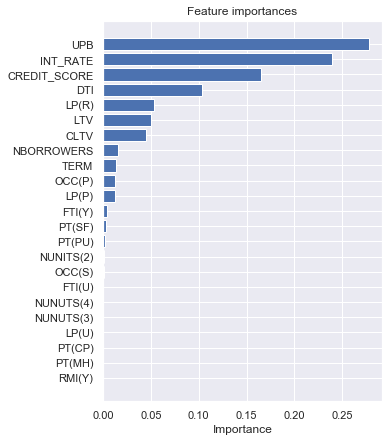

In [289]:
# Get feature_importance of predicting P
Xtrain=A0s.iloc[0:100000,0:23]
Ytrain=A0s['Active12'].iloc[:100000]

from sklearn import tree
import seaborn as sns
sns.set()

clfp=tree.DecisionTreeClassifier(min_samples_split=15,min_samples_leaf=15)
clfp.fit(Xtrain,Ytrain)
features_list = Xtrain.columns.values
feature_importance =clfp.feature_importances_
importance= np.argsort(feature_importance)
 
plt.figure(figsize=(5,7))
plt.barh(range(len(importance)), feature_importance[importance], align='center')
plt.yticks(range(len(importance)), features_list[importance])
plt.xlabel('Importance')
plt.title('Feature importances')
plt.draw()
plt.show()

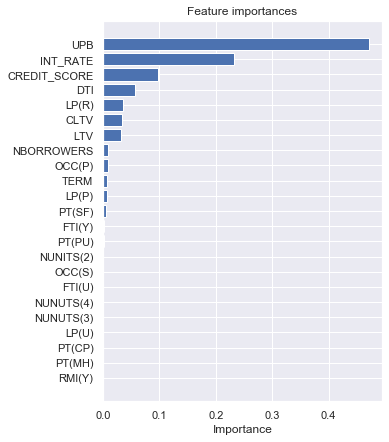

In [290]:
# Get feature_importance of predicting r
Xtrain=A0s.iloc[0:100000,0:23]
Ytrain=A0s['R_12'].iloc[:100000]
from sklearn import tree
import seaborn as sns
sns.set()

clfr=tree.DecisionTreeRegressor(min_samples_split=15,min_samples_leaf=15)
clfr.fit(Xtrain,Ytrain)
features_list = Xtrain.columns.values
feature_importance =clfr.feature_importances_
importance= np.argsort(feature_importance)
 
plt.figure(figsize=(5,7))
plt.barh(range(len(importance)), feature_importance[importance], align='center')
plt.yticks(range(len(importance)), features_list[importance])
plt.xlabel('Importance')
plt.title('Feature importances')
plt.draw()
plt.show()

In [286]:
A0s.columns

Index(['INT_RATE', 'UPB', 'TERM', 'LTV', 'CLTV', 'NBORROWERS', 'DTI',
       'CREDIT_SCORE', 'FTI(U)', 'FTI(Y)', 'LP(P)', 'LP(R)', 'LP(U)', 'PT(CP)',
       'PT(MH)', 'PT(PU)', 'PT(SF)', 'NUNITS(2)', 'NUNUTS(3)', 'NUNUTS(4)',
       'OCC(P)', 'OCC(S)', 'RMI(Y)', 'Duration', 'Revenue', 'Active12',
       'Active24', 'Active36', 'Active48', 'Active60', 'R_12', 'R_24', 'R_36',
       'R_48', 'R_60'],
      dtype='object')

### From feature importance of predicting p and feature importance of predicting r, we can delete some Relatively unimportant variables:NUNITS(2),OCC(S),FTI(U),NUNUTS(3),NUNUTS(4),LP(U),PT(CP),PT(MH),RMI(Y)

In [288]:
#delete these features above
A0t=A0s.drop(['NUNITS(2)','OCC(S)','FTI(U)','NUNUTS(3)','NUNUTS(4)','LP(U)','PT(CP)','PT(MH)','RMI(Y)'],axis=1)

In [304]:
A0t.head()

,INT_RATE,UPB,TERM,LTV,CLTV,NBORROWERS,DTI,CREDIT_SCORE,FTI(Y),LP(P),...,Active12,Active24,Active36,Active48,Active60,R_12,R_24,R_36,R_48,R_60
LID,,,,,,,,,,,,,,,,,,,,,
899994927243,8.000,125000.0,360.0,95.0,95.0,1.0,29.0,694.0,0,1,...,True,False,False,False,False,134924.958470,134924.958470,134924.958470,134924.958470,134924.958470
899979172795,7.125,214000.0,360.0,80.0,80.0,1.0,43.0,731.0,0,1,...,True,True,False,False,False,17301.091678,34602.183357,246689.781622,246689.781622,246689.781622
899959222112,7.000,145000.0,360.0,71.0,71.0,2.0,20.0,752.0,0,1,...,True,True,False,False,False,12540.952034,27975.969922,172019.446026,172019.446026,172019.446026
899958810652,7.875,150000.0,240.0,85.0,85.0,2.0,34.0,734.0,0,0,...,True,True,False,False,False,14916.193698,29832.387396,176882.872753,176882.872753,176882.872753
899952449977,6.750,123000.0,360.0,77.0,77.0,2.0,50.0,684.0,0,0,...,True,False,False,False,False,10371.083564,133253.572266,133253.572266,133253.572266,133253.572266


In [313]:
A0t.to_csv('A0t')

## (However, after trying A0t in models, performances are worse ,so I still use original data A0s)

# 3.Model construction

## 1）Model for predicting p(12),p(24),p(36),p(48),p(60)

In [236]:
Xtrain_1=A0s.iloc[:,0:23]
Ytrain_1_1=A0s['Active12']
Ytrain_1_2=A0s['Active24']
Ytrain_1_3=A0s['Active36']
Ytrain_1_4=A0s['Active48']
Ytrain_1_5=A0s['Active60']

Ytrain_1_6=A0s['R_12']
Ytrain_1_7=A0s['R_24']
Ytrain_1_8=A0s['R_36']
Ytrain_1_9=A0s['R_48']
Ytrain_1_10=A0s['R_60']

### a. Logistic Regression

In [209]:
# Logestic Regression for p(12)
from sklearn.linear_model import LogisticRegression
clfL_1= LogisticRegression(solver='lbfgs').fit(Xtrain_1,Ytrain_1_1)

# Logistic Regression for p(24)
clfL_2= LogisticRegression(solver='lbfgs').fit(Xtrain_1,Ytrain_1_2)

# Logistic Regression for p(36)
clfL_3= LogisticRegression(solver='lbfgs').fit(Xtrain_1,Ytrain_1_3)

# Logistic Regression for p(48)
clfL_4= LogisticRegression(solver='lbfgs').fit(Xtrain_1,Ytrain_1_4)

# Logistic Regression for p(60)
clfL_5= LogisticRegression(solver='lbfgs').fit(Xtrain_1,Ytrain_1_5)

In [124]:
#variables correlation
#k = 10
#corrmat = A0r.iloc[:,:26].corr()
#cols = corrmat.nlargest(k,'P12')['P12'].index  

### b.Decision Tree

In [211]:
#Decision Tree for p(12)
from sklearn import tree
clfT_1=tree.DecisionTreeClassifier(min_samples_split=15,min_samples_leaf=15).fit(Xtrain_1,Ytrain_1_1)

#Decision Tree for p(24)
clfT_2=tree.DecisionTreeClassifier(min_samples_split=15,min_samples_leaf=15).fit(Xtrain_1,Ytrain_1_2)

#Decision Tree for p(36)
clfT_3=tree.DecisionTreeClassifier(min_samples_split=15,min_samples_leaf=15).fit(Xtrain_1,Ytrain_1_3)

#Decision Tree for p(48)
clfT_4=tree.DecisionTreeClassifier(min_samples_split=15,min_samples_leaf=15).fit(Xtrain_1,Ytrain_1_4)

#Decision Tree for p(60)
clfT_5=tree.DecisionTreeClassifier(min_samples_split=15,min_samples_leaf=15).fit(Xtrain_1,Ytrain_1_5)

### c. Random Forest

In [213]:
# Random Forest for p(12)
from sklearn import tree
clfRF_1= tree.DecisionTreeClassifier(max_depth=1).fit(Xtrain_1,Ytrain_1_1)

#Random Forest for p(24)
clfRF_2= tree.DecisionTreeClassifier(max_depth=1).fit(Xtrain_1,Ytrain_1_2)

#Random Forest for p(36)
clfRF_3= tree.DecisionTreeClassifier(max_depth=1).fit(Xtrain_1,Ytrain_1_3)

#Random Forest for p(48)
clfRF_4= tree.DecisionTreeClassifier(max_depth=1).fit(Xtrain_1,Ytrain_1_4)

# Random Forest for p(60)
clfRF_5= tree.DecisionTreeClassifier(max_depth=1).fit(Xtrain_1,Ytrain_1_5)

In [127]:
#SVM
# Give up,Operating time too long...
#from sklearn import svm
#clf4= svm.SVC(kernel='rbf', C=1000) # Inverse of regularization strength.
#clf4.fit(Xtrain1, Ytrain1)

### d.KNN

In [215]:
#KNN for predicting p(m)
from sklearn import neighbors
#KNN for predicting p(12)
clfKNN_1 =neighbors.KNeighborsClassifier(n_neighbors = 7).fit(Xtrain_1,Ytrain_1_1)

#KNN for predicting p(24)
clfKNN_2 =neighbors.KNeighborsClassifier(n_neighbors = 7).fit(Xtrain_1,Ytrain_1_2)

#KNN for predicting p(36)
clfKNN_3 =neighbors.KNeighborsClassifier(n_neighbors = 7).fit(Xtrain_1,Ytrain_1_3)

#KNN for predicting p(48)
clfKNN_4 =neighbors.KNeighborsClassifier(n_neighbors = 7).fit(Xtrain_1,Ytrain_1_4)

#KNN for predicting p(60)
clfKNN_5 =neighbors.KNeighborsClassifier(n_neighbors = 7).fit(Xtrain_1,Ytrain_1_5)

## 2) Models for predicting r(12),r(24),r(36),r(48),r(60)

In [129]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso

### a.Linear Regression

In [237]:
#Linear Regression for r(12)
regLR_1= LinearRegression().fit(Xtrain_1,Ytrain_1_6)

#Linear Regression for r(24)
regLR_2= LinearRegression().fit(Xtrain_1,Ytrain_1_7)

#Linear Regression for r(36)
regLR_3= LinearRegression().fit(Xtrain_1,Ytrain_1_8)

#Linear Regression for r(48)
regLR_4= LinearRegression().fit(Xtrain_1,Ytrain_1_9)

#Linear Regression for r(60)
regLR_5= LinearRegression().fit(Xtrain_1,Ytrain_1_10)

### b.Decision Tree Regression

In [238]:
#Decision Tree Regression for r(12)
regDT_1= DecisionTreeRegressor(random_state = 0).fit(Xtrain_1,Ytrain_1_6) 

#Decision Tree Regression for r(24)
regDT_2= DecisionTreeRegressor(random_state = 0).fit(Xtrain_1,Ytrain_1_7)

#Decision Tree Regression for r(36)
regDT_3= DecisionTreeRegressor(random_state = 0).fit(Xtrain_1,Ytrain_1_8)

#Decision Tree Regression for r(48)
regDT_4= DecisionTreeRegressor(random_state = 0).fit(Xtrain_1,Ytrain_1_9)

#Decision Tree Regression for r(60)
regDT_5= DecisionTreeRegressor(random_state = 0).fit(Xtrain_1,Ytrain_1_10)

### c.Lasso Regression

In [239]:
#Lasso Regression for r(12)
alpha = 0.1
regLR_1= Lasso(alpha=alpha).fit(Xtrain_1,Ytrain_1_6)

#Lasso Regression for r(24)
regLR_2= Lasso(alpha=alpha).fit(Xtrain_1,Ytrain_1_7)

#Lasso Regression for r(36)
regLR_3= Lasso(alpha=alpha).fit(Xtrain_1,Ytrain_1_8)

#Lasso Regression for r(48)
regLR_4= Lasso(alpha=alpha).fit(Xtrain_1,Ytrain_1_9)

#Lasso Regression for r(60)
regLR_5= Lasso(alpha=alpha).fit(Xtrain_1,Ytrain_1_10)

### d.Random Forest Regression

In [240]:
#RandomForestRegression for r(12)
from sklearn.ensemble import RandomForestRegressor
regRFR_1=RandomForestRegressor(n_estimators = 10).fit(Xtrain_1,Ytrain_1_6)

#RandomForestRegression for r(24)
regRFR_2=RandomForestRegressor(n_estimators = 10).fit(Xtrain_1,Ytrain_1_7)

#RandomForestRegression for r(36)
regRFR_3=RandomForestRegressor(n_estimators = 10).fit(Xtrain_1,Ytrain_1_8)

#RandomForestRegression for r(48)
regRFR_4=RandomForestRegressor(n_estimators = 10).fit(Xtrain_1,Ytrain_1_9)

#RandomForestRegression for r(60)
regRFR_5=RandomForestRegressor(n_estimators = 10).fit(Xtrain_1,Ytrain_1_10)

# 4.Use A1 to test models and select model

## 1）Data Processing(similar to A0 data processing,so simplify explanation here)

### a.Missing value processing

In [76]:
A1=pd.read_csv('A1.csv')

In [77]:
CF1=pd.read_csv('CASH_FLOW1.csv')

In [78]:
A1a=A1.set_index(['LID'],inplace=False)

In [79]:
A1a.shape

(156564, 25)

In [80]:
#Calculate number of missing value
NANnum1=[A1a.iloc[:,i].isna().sum() for i in range(25)]
NANnum1=pd.DataFrame({'Feature Name':A0a.columns,"NAN number":NANnum1})

NANnum1

,Feature Name,NAN number
0,OCHANNEL,0
1,SELLER,0
2,INT_RATE,0
3,UPB,0
4,TERM,0
5,ORIG_DATE,0
6,FIRST_PMT_DATE,0
7,LTV,1
8,CLTV,13
9,NBORROWERS,180


In [81]:
# drop rows of missing value of 'LTV','NBORROWERS'and 'DTI'(because the missing rate of these variables are very small )
A1d=A1a[A1a['CLTV'].notna()]
A1e=A1d[A1d['NBORROWERS'].notna()]
A1e=A1e[A1e['LTV'].notna()]

In [82]:
A1e.shape

(156374, 25)

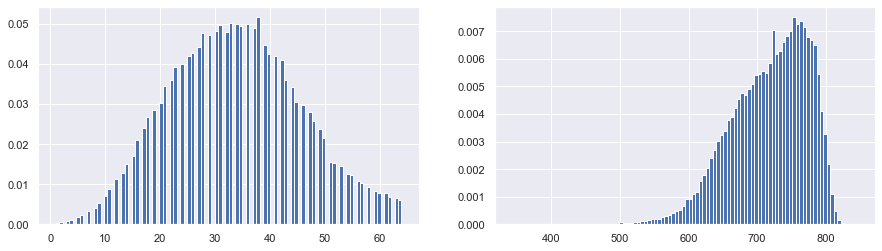

In [249]:
# impulate missing value of 'DTI' and 'CREDIT_SCORE'
import seaborn as sns
sns.set()
fig=plt.figure(figsize=(15,4))
ax1=fig.add_subplot(121)
A1e['DTI'].hist(bins=100,density=1)
ax2=fig.add_subplot(122)
A1e['CREDIT_SCORE'].hist(bins=100,density=1)

In [83]:
# normal distributed, suitable for mean impulation
A1e['DTI']=A1e['DTI'].fillna(A1e['DTI'].mean())

#skewed distributed, suitible for median imputation
A1e['CREDIT_SCORE']=A1e['CREDIT_SCORE'].fillna(A1e['CREDIT_SCORE'].median())

In [84]:
#NANnum=[A0e.iloc[:,i].isna().sum() for i in range(32)]
#NANnum=pd.DataFrame({'Feature Name':A0e.columns,"NAN number":NANnum})
#NANnum

In [85]:
# drop columns'FIRST_TIME_IND'and'CO_CREDIT_SCORE'and'MORT_INS_TYPE'

In [86]:
A1f=A1e.drop(['MORT_INS_PCT'],axis=1)
A1g=A1f.drop(['CO_CREDIT_SCORE'],axis=1)
A1h=A1g.drop(['MORT_INS_TYPE'],axis=1)

In [87]:
A1h.shape

(156374, 22)

In [88]:
A1h.head()

,OCHANNEL,SELLER,INT_RATE,UPB,TERM,ORIG_DATE,FIRST_PMT_DATE,LTV,CLTV,NBORROWERS,...,FIRST_TIME_IND,LOAN_PURPOSE,PROPERTY_TYPE,NUNITS,OCC_STATUS,STATE,ZIP,PROD_TYPE,REL_MORT_IND,group
LID,,,,,,,,,,,,,,,,,,,,,
899989724263,R,"JPMORGAN CHASE BANK, NA",7.625,140000.0,360.0,2000-12-01,2001-02-01,21.0,21.0,1.0,...,N,R,SF,1,P,CO,803,FRM,N,1
899972652340,R,OTHER,8.000,195000.0,360.0,2000-12-01,2001-02-01,74.0,74.0,2.0,...,N,C,SF,1,P,VA,236,FRM,N,1
899956491317,R,OTHER,7.125,108000.0,360.0,2001-01-01,2001-03-01,86.0,86.0,1.0,...,N,P,CO,1,P,IL,601,FRM,N,1
899914532096,R,"GMAC MORTGAGE, LLC",7.625,48000.0,360.0,2000-12-01,2001-02-01,62.0,62.0,2.0,...,N,C,SF,1,P,MS,395,FRM,N,1
899903298523,B,FIRST TENNESSEE BANK NATIONAL ASSOCIATION,7.625,108000.0,360.0,2001-02-01,2001-04-01,59.0,59.0,2.0,...,N,C,SF,1,P,MO,633,FRM,N,1


In [89]:
NANnum=[A1h.iloc[:,i].isna().sum() for i in range(22)]
NANnum=pd.DataFrame({'Feature Name':A1h.columns,"NAN number":NANnum})
NANnum
# Now there are no missing values in dataframe

,Feature Name,NAN number
0,OCHANNEL,0
1,SELLER,0
2,INT_RATE,0
3,UPB,0
4,TERM,0
5,ORIG_DATE,0
6,FIRST_PMT_DATE,0
7,LTV,0
8,CLTV,0
9,NBORROWERS,0


## 2) Feature Selection

### a. Remove feature with zero variance

In [90]:
#Get all value of 'PROD_TYPE'
A1h['PROD_TYPE'].unique()

array(['FRM'], dtype=object)

In [91]:
#'PROD_TYPE'only has one value, so we drop this variable
A1i=A1h.drop(['PROD_TYPE'],axis=1)

### b.Drop useless columns

In [92]:
#Drop 'ORIG_DATE','FIRST_PMT_DATE','SELLER','ZIP','STATE' ,'OCHANNEL'and'group
A1j=A1i.drop(['ORIG_DATE'],axis=1)
A1j=A1j.drop(['FIRST_PMT_DATE'],axis=1)
A1j=A1j.drop(['SELLER'],axis=1)
A1j=A1j.drop(['ZIP'],axis=1)
A1j=A1j.drop(['STATE'],axis=1)
A1j=A1j.drop(['OCHANNEL'],axis=1)
A1j=A1j.drop(['group'],axis=1)

In [93]:
A1j.shape

(156374, 14)

## 3) Dummy Variables

### a.Get value of each character variable

In [259]:
A1j['FIRST_TIME_IND'].unique()

array(['N', 'Y', 'U'], dtype=object)

In [260]:
A1j['LOAN_PURPOSE'].unique()

array(['R', 'C', 'P', 'U'], dtype=object)

In [262]:
A1j['PROPERTY_TYPE'].unique()

array(['SF', 'CO', 'PU', 'MH', 'CP'], dtype=object)

In [263]:
A1j['NUNITS'].unique()

array([1, 4, 2, 3], dtype=int64)

In [264]:
A1j['OCC_STATUS'].unique()

array(['P', 'S', 'I'], dtype=object)

In [261]:
A1j['REL_MORT_IND'].unique()

array(['N', 'Y'], dtype=object)

### b. Get dummies

In [94]:
#Get dummies of each character variable and change their columns names
FIRST_TIME_IND_dummy=pd.get_dummies(A1j["FIRST_TIME_IND"],drop_first=True)
FIRST_TIME_IND_dummy.columns=['FTI(U)','FTI(Y)']

LOAN_PURPOSE_dummy=pd.get_dummies(A1j["LOAN_PURPOSE"],drop_first=True)
LOAN_PURPOSE_dummy.columns=['LP(P)','LP(R)','LP(U)']

PROPERTY_TYPE_dummy=pd.get_dummies(A1j["PROPERTY_TYPE"],drop_first=True)
PROPERTY_TYPE_dummy.columns=['PT(CP)','PT(MH)','PT(PU)','PT(SF)']

NUNITS_dummy=pd.get_dummies(A1j["NUNITS"],drop_first=True)
NUNITS_dummy.columns=['NUNITS(2)','NUNUTS(3)','NUNUTS(4)']

OCC_STATUS_dummy=pd.get_dummies(A1j["OCC_STATUS"],drop_first=True)
OCC_STATUS_dummy.columns=['OCC(P)','OCC(S)']

REL_MORT_IND_dummy=pd.get_dummies(A1j["REL_MORT_IND"],drop_first=True)
REL_MORT_IND_dummy.columns=['RMI(Y)']

In [95]:
#Merge dummies to original dataframe
A1k=A1j.merge(FIRST_TIME_IND_dummy,how='inner',left_on='LID',right_on='LID')
A1l=A1k.merge(LOAN_PURPOSE_dummy,how='inner',left_on='LID',right_on='LID')
A1m=A1l.merge(PROPERTY_TYPE_dummy,how='inner',left_on='LID',right_on='LID')
A1n=A1m.merge(NUNITS_dummy,how='inner',left_on='LID',right_on='LID')
A1o=A1n.merge(OCC_STATUS_dummy,how='inner',left_on='LID',right_on='LID')
A1p=A1o.merge(REL_MORT_IND_dummy,how='inner',left_on='LID',right_on='LID')

In [96]:
#Drop original columns of character variables
A1p=A1p.drop(['FIRST_TIME_IND'],axis=1)
A1p=A1p.drop(['LOAN_PURPOSE'],axis=1)
A1p=A1p.drop(['PROPERTY_TYPE'],axis=1)
A1p=A1p.drop(['NUNITS'],axis=1)
A1p=A1p.drop(['OCC_STATUS'],axis=1)
A1p=A1p.drop(['REL_MORT_IND'],axis=1)

In [97]:
A1p.shape

(156374, 23)

In [47]:
#A0p.to_csv('A0p.csv')

## 4) Create new variables

### a.Calculate loan duration of each LID

In [98]:
#Calculate loan duration of each LID
Payment_duration=pd.DataFrame(CF1['LID'].value_counts()-1)
Payment_duration.columns=['Duration']
Payment_duration['LID']=Payment_duration.index
Payment_duration.set_index(['LID'],inplace=True)
Payment_duration.head()

,Duration
LID,
640015701124,244
112523617112,241
749417459400,241
378042349198,240
680454170948,240


In [99]:
A1q=A1p.merge(Payment_duration,how='inner',left_on='LID',right_on='LID')

### b.Calculate revenue for each LID

In [100]:
#Calculate revenue for each LID
CF1a=pd.DataFrame(CF1.groupby('LID')['PAYMENT'].sum())
CF1a.columns=['Revenue']

In [101]:
A1r=A1q.merge(CF1a,how='inner',left_on='LID',right_on='LID')

### c.Create boolean variables of whether loans are active for loan age 12,24,36,48,60

In [103]:
# Create boolean variables of whether loans are active for loan age 12,24,36,48,60
P12=[A1r.iloc[i,23]>=12 for i in range(len(A1r))]
P24=[A1r.iloc[i,23]>=24 for i in range(len(A1r))]
P36=[A1r.iloc[i,23]>=36 for i in range(len(A1r))]
P48=[A1r.iloc[i,23]>=48 for i in range(len(A1r))]
P60=[A1r.iloc[i,23]>=60 for i in range(len(A1r))]

In [104]:
#Concatenate these boolean variables above to A0c
A1r['Active12']=P12
A1r['Active24']=P24
A1r['Active36']=P36
A1r['Active48']=P48
A1r['Active60']=P60

In [105]:
A1r.head()

,INT_RATE,UPB,TERM,LTV,CLTV,NBORROWERS,DTI,CREDIT_SCORE,FTI(U),FTI(Y),...,OCC(P),OCC(S),RMI(Y),Duration,Revenue,Active12,Active24,Active36,Active48,Active60
LID,,,,,,,,,,,,,,,,,,,,,
899989724263,7.625,140000.0,360.0,21.0,21.0,1.0,12.0,796.0,0,0,...,1,0,0,23,157828.401485,True,False,False,False,False
899972652340,8.000,195000.0,360.0,74.0,74.0,2.0,42.0,720.0,0,0,...,1,0,0,19,219545.053154,True,False,False,False,False
899956491317,7.125,108000.0,360.0,86.0,86.0,1.0,31.0,779.0,0,0,...,1,0,0,24,122610.439114,True,True,False,False,False
899914532096,7.625,48000.0,360.0,62.0,62.0,2.0,23.0,624.0,0,0,...,1,0,0,20,54042.347860,True,False,False,False,False
899903298523,7.625,108000.0,360.0,59.0,59.0,2.0,19.0,528.0,0,0,...,1,0,0,5,111436.027855,False,False,False,False,False


In [106]:
#A0r.to_csv('A0r.csv')
A1r.shape

(156374, 30)

### d.Create R(12),R(24),R(36),R(48),R(60)

In [109]:
CF1.head()

,LID,LOAN_AGE,PAYMENT,group
0,899989724263,0.0,0.000000,1
1,899989724263,1.0,990.911245,1
2,899989724263,2.0,990.911245,1
3,899989724263,3.0,2972.733735,1
4,899989724263,4.0,2972.733735,1


In [107]:
#Define a function to calculate revenue
C=CF1.groupby('LID')
def revenue_calculator(LID,duration):
    revenue=C.get_group(LID)['PAYMENT'].iloc[:(duration+1)].sum()
    return(revenue)

In [110]:
revenue_calculator(899989724263,12)

29727.33734689464

In [111]:
#Create R(12),R(24),R(36),R(48),R(60)
#time-consuming...
R12=np.zeros([len(A1r)])
R24=np.zeros([len(A1r)])
R36=np.zeros([len(A1r)])
R48=np.zeros([len(A1r)])
R60=np.zeros([len(A1r)])

L=list(A1r.index)
for i in range(len(A1r)):
    Z=A1r.loc[L[i]]['Duration']
    R=A1r.loc[L[i]]['Revenue']
    if Z<=12:
        R12[i]=R
        R24[i]=R
        R36[i]=R
        R48[i]=R
        R60[i]=R
    elif Z<=24:
        R12[i]=revenue_calculator(L[i],12)
        R24[i]=R
        R36[i]=R
        R48[i]=R
        R60[i]=R
    elif Z<=36:
        R12[i]=revenue_calculator(L[i],12)
        R24[i]=revenue_calculator(L[i],24)
        R36[i]=R
        R48[i]=R
        R60[i]=R
    elif Z<=48:
        R12[i]=revenue_calculator(L[i],12)
        R24[i]=revenue_calculator(L[i],24)
        R36[i]=revenue_calculator(L[i],36)
        R48[i]=R
        R60[i]=R
    elif Z<=60:
        R12[i]=revenue_calculator(L[i],12)
        R24[i]=revenue_calculator(L[i],24)
        R36[i]=revenue_calculator(L[i],36)
        R48[i]=revenue_calculator(L[i],48)
        R60[i]=R
    elif Z>60:
        R12[i]=revenue_calculator(L[i],12)
        R24[i]=revenue_calculator(L[i],24)
        R36[i]=revenue_calculator(L[i],36)
        R48[i]=revenue_calculator(L[i],48)
        R60[i]=revenue_calculator(L[i],60)

In [112]:
R120=pd.DataFrame({'LID':A1r.index,'R_12':R12})
R240=pd.DataFrame({'LID':A1r.index,'R_24':R24})
R360=pd.DataFrame({'LID':A1r.index,'R_36':R36})
R480=pd.DataFrame({'LID':A1r.index,'R_48':R48})
R600=pd.DataFrame({'LID':A1r.index,'R_60':R60})

In [113]:
R120.set_index('LID',inplace=True)
R240.set_index('LID',inplace=True)
R360.set_index('LID',inplace=True)
R480.set_index('LID',inplace=True)
R600.set_index('LID',inplace=True)

In [114]:
R240.head()

,R_24
LID,
899989724263,157828.401485
899972652340,219545.053154
899956491317,122610.439114
899914532096,54042.347860
899903298523,111436.027855


In [115]:
A1s=A1r.merge(R120,how='inner',left_on='LID',right_on='LID')
A1s=A1s.merge(R240,how='inner',left_on='LID',right_on='LID')
A1s=A1s.merge(R360,how='inner',left_on='LID',right_on='LID')
A1s=A1s.merge(R480,how='inner',left_on='LID',right_on='LID')
A1s=A1s.merge(R600,how='inner',left_on='LID',right_on='LID')

In [116]:
A1s.head()

,INT_RATE,UPB,TERM,LTV,CLTV,NBORROWERS,DTI,CREDIT_SCORE,FTI(U),FTI(Y),...,Active12,Active24,Active36,Active48,Active60,R_12,R_24,R_36,R_48,R_60
LID,,,,,,,,,,,,,,,,,,,,,
899989724263,7.625,140000.0,360.0,21.0,21.0,1.0,12.0,796.0,0,0,...,True,False,False,False,False,29727.337347,157828.401485,157828.401485,157828.401485,157828.401485
899972652340,8.000,195000.0,360.0,74.0,74.0,2.0,42.0,720.0,0,0,...,True,False,False,False,False,17170.091029,219545.053154,219545.053154,219545.053154,219545.053154
899956491317,7.125,108000.0,360.0,86.0,86.0,1.0,31.0,779.0,0,0,...,True,True,False,False,False,14552.320103,122610.439114,122610.439114,122610.439114,122610.439114
899914532096,7.625,48000.0,360.0,62.0,62.0,2.0,23.0,624.0,0,0,...,True,False,False,False,False,4076.891979,54042.347860,54042.347860,54042.347860,54042.347860
899903298523,7.625,108000.0,360.0,59.0,59.0,2.0,19.0,528.0,0,0,...,False,False,False,False,False,111436.027855,111436.027855,111436.027855,111436.027855,111436.027855


In [250]:
A1s.to_csv('A1s.csv')

## 2）Apply these models to A1

In [242]:
XtestA1=A1s.iloc[:,:23]
YtestA1_1=A1s['Active12']
YtestA1_2=A1s['Active24']
YtestA1_3=A1s['Active36']
YtestA1_4=A1s['Active48']
YtestA1_5=A1s['Active60']

YtestA1_6=A1s['R_12']
YtestA1_7=A1s['R_24']
YtestA1_8=A1s['R_36']
YtestA1_9=A1s['R_48']
YtestA1_10=A1s['R_60']

## 1）Model for predicting p(12),p(24),p(36),p(48),p(60)

### a. Logistic Regression

In [243]:
# Logestic Regression for p(12)
Ypred1=clfL_1.predict(XtestA1)
probL1=clfL_1.predict_proba(XtestA1)
#performance of p(12)
perfL_p12=average(abs(probL1[:,1]-YtestA1_1))
print('The performance of Logistic Regression when m=12 is:',perfL_p12)

# Logestic Regression for p(24)
Ypred2=clfL_2.predict(XtestA1)
probL2=clfL_2.predict_proba(XtestA1)
#performance of p(24)
perfL_p24=average(abs(probL2[:,1]-YtestA1_2))
print('The performance of Logistic Regression when m=24 is:',perfL_p24)

# Logestic Regression for p(36)
Ypred3=clfL_3.predict(XtestA1)
probL3=clfL_3.predict_proba(XtestA1)
#performance of p(36)
perfL_p36=average(abs(probL3[:,1]-YtestA1_3))
print('The performance of Logistic Regression when m=36 is:',perfL_p36)

# Logestic Regression for p(48)
Ypred4=clfL_4.predict(XtestA1)
probL4=clfL_4.predict_proba(XtestA1)
#performance of p(48)
perfL_p48=average(abs(probL4[:,1]-YtestA1_4))
print('The performance of Logistic Regression when m=48 is:',perfL_p48)

# Logestic Regression for p(60)
Ypred5=clfL_5.predict(XtestA1)
probL5=clfL_5.predict_proba(XtestA1)
#performance of p(60)
perfL_p60=average(abs(probL5[:,1]-YtestA1_5))
print('The performance of Logistic Regression when m=60 is:',perfL_p60)

The performance of Logistic Regression when m=12 is: 0.2793381105740657
The performance of Logistic Regression when m=24 is: 0.46916789000730524
The performance of Logistic Regression when m=36 is: 0.3085718954736448
The performance of Logistic Regression when m=48 is: 0.21854501541515503
The performance of Logistic Regression when m=60 is: 0.16731348505110705


In [141]:
#variables correlation
#k = 10
#corrmat = A0r.iloc[:,:26].corr()
#cols = corrmat.nlargest(k,'P12')['P12'].index  

### b.Decision Tree

In [212]:
#Decision Tree for p(12)
probDT1=clfT_1.predict_proba(XtestA1)
#performance of p(12)
perfDT_p12=average(abs(probDT1[:,1]-YtestA1_1))
print('The performance of Decision Tree when m=12 is:',perfDT_p12)

#Decision Tree for p(24)
probDT2=clfT_2.predict_proba(XtestA1)
#performance of p(24)
perfDT_p24=average(abs(probDT2[:,1]-YtestA1_2))
print('The performance of Decision Tree when m=24 is:',perfDT_p24)

#Decision Tree for p(36)
probDT3=clfT_3.predict_proba(XtestA1)
#performance of p(36)
perfDT_p36=average(abs(probDT3[:,1]-YtestA1_3))
print('The performance of Decision Tree when m=36 is:',perfDT_p36)

#Decision Tree for p(48)
probDT4=clfT_4.predict_proba(XtestA1)
#performance of p(48)
perfDT_p48=average(abs(probDT4[:,1]-YtestA1_4))
print('The performance of Decision Tree when m=48 is:',perfDT_p48)

#Decision Tree for p(60)
probDT5=clfT_5.predict_proba(XtestA1)
#performance of p(60)
perfDT_p60=average(abs(probDT5[:,1]-YtestA1_5))
print('The performance of Decision Tree when m=60 is:',perfDT_p60)


The performance of Decision Tree when m=12 is: 0.24479079881392407
The performance of Decision Tree when m=24 is: 0.4220483287358667
The performance of Decision Tree when m=36 is: 0.29041584990920943
The performance of Decision Tree when m=48 is: 0.20738310712158886
The performance of Decision Tree when m=60 is: 0.1603638478233097


### c. Random Forest

In [214]:
# Random Forest for p(12)
probRF1=clfRF_1.predict_proba(XtestA1)
#performance of p(12)
perfRF_p12=average(abs(probRF1[:,1]-YtestA1_1))
print('The performance of Random Forest when m=12 is:',perfRF_p12)

# Random Forest for p(24)
probRF2=clfRF_2.predict_proba(XtestA1)
#performance of p(24)
perfRF_p24=average(abs(probRF2[:,1]-YtestA1_2))
print('The performance of Random Forest when m=24 is:',perfRF_p24)

# Random Forest for p(12)
probRF3=clfRF_3.predict_proba(XtestA1)
#performance of p(12)
perfRF_p36=average(abs(probRF3[:,1]-YtestA1_3))
print('The performance of Random Forest when m=36 is:',perfRF_p36)

# Random Forest for p(12)
probRF4=clfRF_4.predict_proba(XtestA1)
#performance of p(12)
perfRF_p48=average(abs(probRF4[:,1]-YtestA1_4))
print('The performance of Random Forest when m=48 is:',perfRF_p48)

# Random Forest for p(12)
probRF5=clfRF_5.predict_proba(XtestA1)
#performance of p(12)
perfRF_p60=average(abs(probRF5[:,1]-YtestA1_5))
print('The performance of Random Forest when m=60 is:',perfRF_p60)

The performance of Random Forest when m=12 is: 0.27476133742756625
The performance of Random Forest when m=24 is: 0.4749233291936638
The performance of Random Forest when m=36 is: 0.31551363406784116
The performance of Random Forest when m=48 is: 0.2231591503840642
The performance of Random Forest when m=60 is: 0.17050896936290208


### d.KNN

In [216]:
# KNN for p(12)
probKNN1=clfKNN_1.predict_proba(XtestA1)
#performance of p(12)
perfKNN_p12=average(abs(probKNN1[:,1]-YtestA1_1))
print('The performance of Random Forest when m=12 is:',perfKNN_p12)

# KNN for p(24)
probKNN2=clfKNN_2.predict_proba(XtestA1)
#performance of p(24)
perfKNN_p24=average(abs(probKNN2[:,1]-YtestA1_2))
print('The performance of Random Forest when m=24 is:',perfKNN_p24)

# KNN for p(36)
probKNN3=clfKNN_3.predict_proba(XtestA1)
#performance of p(36)
perfKNN_p36=average(abs(probKNN3[:,1]-YtestA1_3))
print('The performance of Random Forest when m=36 is:',perfKNN_p36)

# KNN for p(48)
probKNN4=clfKNN_4.predict_proba(XtestA1)
#performance of p(48)
perfKNN_p48=average(abs(probKNN4[:,1]-YtestA1_4))
print('The performance of Random Forest when m=48 is:',perfKNN_p48)

# KNN for p(60)
probKNN5=clfKNN_5.predict_proba(XtestA1)
#performance of p(60)
perfKNN_p60=average(abs(probKNN5[:,1]-YtestA1_5))
print('The performance of Random Forest when m=60 is:',perfKNN_p60)

The performance of Random Forest when m=12 is: 0.2742025071760194
The performance of Random Forest when m=24 is: 0.4586778218520069
The performance of Random Forest when m=36 is: 0.3022104514999753
The performance of Random Forest when m=48 is: 0.21560306883314537
The performance of Random Forest when m=60 is: 0.16558561982353662


## 2) Model for predicting r(12),r(24),r(36),r(48),r(60)

### a.Linear Regression

In [255]:
#Linear Regression for r(12)
R_12LR_pred=regLR_1.predict(XtestA1)
#performance of r(12)
perfLR_r12=average(abs(R_12LR_pred-YtestA1_6))
print('The performance of Linear Regression when m=12 is:',perfLR_r12)

#Linear Regression for r(24)
R_24LR_pred=regLR_1.predict(XtestA1)
#performance of r(24)
perfLR_r24=average(abs(R_24LR_pred-YtestA1_7))
print('The performance of Linear Regression when m=24 is:',perfLR_r24)

#Linear Regression for r(36)
R_36LR_pred=regLR_1.predict(XtestA1)
#performance of r(36)
perfLR_r36=average(abs(R_36LR_pred-YtestA1_8))
print('The performance of Linear Regression when m=36 is:',perfLR_r36)

#Linear Regression for r(48)
R_48LR_pred=regLR_1.predict(XtestA1)
#performance of r(48)
perfLR_r48=average(abs(R_48LR_pred-YtestA1_9))
print('The performance of Linear Regression when m=48 is:',perfLR_r48)

#Linear Regression for r(60)
R_60LR_pred=regLR_1.predict(XtestA1)
#performance of r(60)
perfLR_r60=average(abs(R_60LR_pred-YtestA1_10))
print('The performance of Linear Regression when m=60 is:',perfLR_r60)

The performance of Linear Regression when m=12 is: 44791.56191836879
The performance of Linear Regression when m=24 is: 69759.80359779684
The performance of Linear Regression when m=36 is: 93610.10672936591
The performance of Linear Regression when m=48 is: 100894.11712036171
The performance of Linear Regression when m=60 is: 104720.64226325564


### b.Decision Tree Regression

In [226]:
#Decision Tree Regression for r(12)
R_12DTR_pred=regDT_1.predict(XtestA1)
#perform of r(12)
perfDTR_r12=average(abs(R_12DTR_pred-YtestA1_6))
print('The performance of Decision Tree Regression when m=12 is:',perfDTR_r12)

#Decision Tree Regression for r(24)
R_24DTR_pred=regDT_2.predict(XtestA1)
#perform of r(24)
perfDTR_r24=average(abs(R_24DTR_pred-YtestA1_7))
print('The performance of Decision Tree Regression when m=24 is:',perfDTR_r24)

#Decision Tree Regression for r(36)
R_36DTR_pred=regDT_3.predict(XtestA1)
#perform of r(36)
perfDTR_r36=average(abs(R_36DTR_pred-YtestA1_8))
print('The performance of Decision Tree Regression when m=36 is:',perfDTR_r36)

#Decision Tree Regression for r(48)
R_48DTR_pred=regDT_4.predict(XtestA1)
#perform of r(48)
perfDTR_r48=average(abs(R_48DTR_pred-YtestA1_9))
print('The performance of Decision Tree Regression when m=48 is:',perfDTR_r48)

#Decision Tree Regression for r(60)
R_60DTR_pred=regDT_5.predict(XtestA1)
#perform of r(60)
perfDTR_r60=average(abs(R_60DTR_pred-YtestA1_10))
print('The performance of Decision Tree Regression when m=60 is:',perfDTR_r60)

The performance of Decision Tree Regression when m=12 is: 44970.71091571157
The performance of Decision Tree Regression when m=24 is: 102435.56801027145
The performance of Decision Tree Regression when m=36 is: 136080.81369777935
The performance of Decision Tree Regression when m=48 is: 145004.92626959228
The performance of Decision Tree Regression when m=60 is: 149200.62687646644


### c.Lasso Regression

In [227]:
#Lasso Regression for r(12)
R_12Lasso_pred =regLaR_1.predict(XtestA1)
#perform of r(12)
perfLasso_r12=average(abs(R_12Lasso_pred-YtestA1_6))
print('The performance of Lasso Regression when m=12 is:',perfLasso_r12)

#Lasso Regression for r(24)
R_24Lasso_pred =regLaR_2.predict(XtestA1)
#perform of r(24)
perfLasso_r24=average(abs(R_12Lasso_pred-YtestA1_7))
print('The performance of Lasso Regression when m=24 is:',perfLasso_r24)

#Lasso Regression for r(36)
R_36Lasso_pred =regLaR_3.predict(XtestA1)
#perform of r(36)
perfLasso_r36=average(abs(R_36Lasso_pred-YtestA1_8))
print('The performance of Lasso Regression when m=36 is:',perfLasso_r36)

#Lasso Regression for r(48)
R_48Lasso_pred =regLaR_4.predict(XtestA1)
#perform of r(48)
perfLasso_r48=average(abs(R_48Lasso_pred-YtestA1_9))
print('The performance of Lasso Regression when m=48 is:',perfLasso_r48)

#Lasso Regression for r(60)
R_60Lasso_pred =regLaR_5.predict(XtestA1)
#perform of r(60)
perfLasso_r60=average(abs(R_60Lasso_pred-YtestA1_10))
print('The performance of Lasso Regression when m=60 is:',perfLasso_r60)

The performance of Lasso Regression when m=12 is: 44971.417950047304
The performance of Lasso Regression when m=24 is: 102435.95847031695
The performance of Lasso Regression when m=36 is: 136080.94264984992
The performance of Lasso Regression when m=48 is: 145004.9778447555
The performance of Lasso Regression when m=60 is: 149200.64296580912


### d.Random Forest Regression

In [228]:
#RandomForestRegression for r(12)
R_12RFR_pred=regRFR_1.predict(XtestA1)
#performance of r(12)
perfRFR_r12=average(abs(R_12RFR_pred-YtestA1_6))
print('The performance of Random Forest Regression when m=12 is:',perfRFR_r12)

#RandomForestRegression for r(24)
R_24RFR_pred=regRFR_2.predict(XtestA1)
#performance of r(24)
perfRFR_r24=average(abs(R_24RFR_pred-YtestA1_7))
print('The performance of Random Forest Regression when m=24 is:',perfRFR_r24)

#RandomForestRegression for r(36)
R_36RFR_pred=regRFR_3.predict(XtestA1)
#performance of r(36)
perfRFR_r36=average(abs(R_36RFR_pred-YtestA1_8))
print('The performance of Random Forest Regression when m=36 is:',perfRFR_r36)

#RandomForestRegression for r(48)
R_48RFR_pred=regRFR_4.predict(XtestA1)
#performance of r(48)
perfRFR_r48=average(abs(R_48RFR_pred-YtestA1_9))
print('The performance of Random Forest Regression when m=48 is:',perfRFR_r48)

#RandomForestRegression for r(60)
R_60RFR_pred=regRFR_5.predict(XtestA1)
#performance of r(60)
perfRFR_r60=average(abs(R_60RFR_pred-YtestA1_10))
print('The performance of Random Forest Regression when m=60 is:',perfRFR_r60)

The performance of Random Forest Regression when m=12 is: 44970.710281015265
The performance of Random Forest Regression when m=24 is: 102435.56954889346
The performance of Random Forest Regression when m=36 is: 136080.812236102
The performance of Random Forest Regression when m=48 is: 145004.92465431947
The performance of Random Forest Regression when m=60 is: 149200.62836504664


# 4.Model Comparison

## 1）compare models for predicting p

In [229]:
ModelList1=['Logistic Regression','Decision Tree','Random Forest','KNN']
Error1=[perfL_p12,perfDT_p12,perfRF_p12,perfKNN_p12]
Error2=[perfL_p24,perfDT_p24,perfRF_p24,perfKNN_p24]
Error3=[perfL_p36,perfDT_p36,perfRF_p36,perfKNN_p36]
Error4=[perfL_p48,perfDT_p48,perfRF_p48,perfKNN_p48]
Error5=[perfL_p60,perfDT_p60,perfRF_p60,perfKNN_p60]

P12Comp=pd.DataFrame({'Model':ModelList1,'m=12':Error1}).set_index(['Model'],inplace=False)
P24Comp=pd.DataFrame({'Model':ModelList1,'m=24':Error2}).set_index(['Model'],inplace=False)
P36Comp=pd.DataFrame({'Model':ModelList1,'m=36':Error3}).set_index(['Model'],inplace=False)
P48Comp=pd.DataFrame({'Model':ModelList1,'m=48':Error4}).set_index(['Model'],inplace=False)
P60Comp=pd.DataFrame({'Model':ModelList1,'m=60':Error5}).set_index(['Model'],inplace=False)

In [230]:
PCompare=P12Comp.join(P24Comp).join(P36Comp).join(P48Comp).join(P60Comp)

In [231]:
PCompare=P12Comp.join(P24Comp).join(P36Comp).join(P48Comp).join(P60Comp)

In [232]:
PCompare

,m=12,m=24,m=36,m=48,m=60
Model,,,,,
Logistic Regression,0.279338,0.469168,0.308572,0.218545,0.167313
Decision Tree,0.244791,0.422048,0.290416,0.207383,0.160364
Random Forest,0.274761,0.474923,0.315514,0.223159,0.170509
KNN,0.274203,0.458678,0.302210,0.215603,0.165586


### We can find that Decision Tree performs better at all 5 time points
### So we choose Decision Tree for m=12,24,36,48,60

## 1）Compare models for predicting r

In [245]:
Modellist2=['linear Regression','Decision Tree Regression','Lasso Regression','RandomForestRegression']
Error1=[perfLR_r12,perfDTR_r12,perfLasso_r12,perfRFR_r12]
Error2=[perfLR_r24,perfDTR_r24,perfLasso_r24,perfRFR_r24]
Error3=[perfLR_r36,perfDTR_r36,perfLasso_r36,perfRFR_r36]
Error4=[perfLR_r48,perfDTR_r48,perfLasso_r48,perfRFR_r48]
Error5=[perfLR_r60,perfDTR_r60,perfLasso_r60,perfRFR_r60]

R12Comp=pd.DataFrame({'Model':Modellist2,'m=12':Error1}).set_index(['Model'],inplace=False)
R24Comp=pd.DataFrame({'Model':Modellist2,'m=24':Error2}).set_index(['Model'],inplace=False)
R36Comp=pd.DataFrame({'Model':Modellist2,'m=36':Error3}).set_index(['Model'],inplace=False)
R48Comp=pd.DataFrame({'Model':Modellist2,'m=48':Error4}).set_index(['Model'],inplace=False)
R60Comp=pd.DataFrame({'Model':Modellist2,'m=60':Error5}).set_index(['Model'],inplace=False)

In [246]:
RCompare=R12Comp.join(R24Comp).join(R36Comp).join(R48Comp).join(R60Comp)

In [247]:
RCompare

,m=12,m=24,m=36,m=48,m=60
Model,,,,,
linear Regression,44791.561918,69759.803598,93610.106729,100894.117120,104720.642263
Decision Tree Regression,44970.710916,102435.568010,136080.813698,145004.926270,149200.626876
Lasso Regression,44971.417950,102435.958470,136080.942650,145004.977845,149200.642966
RandomForestRegression,44970.710281,102435.569549,136080.812236,145004.924654,149200.628365


### From this dataframe we find that linear regression performs best at all 5 points ,so we choose linear regression

# 5. Predict p(12),p(24),p(36),p(48),p(60) and r(12),r(24),r(36),r(48),r(60) of A2

## 1) Data Processing(similar to A0 data processing,so simplify explanation here)

In [258]:
A2=pd.read_csv('A2.csv')

In [259]:
A2a=A2.set_index(['LID'],inplace=False)
A2a.shape

(156564, 25)

In [260]:
#Calculate number of missing value
NANnum2=[A1a.iloc[:,i].isna().sum() for i in range(25)]
NANnum2=pd.DataFrame({'Feature Name':A0a.columns,"NAN number":NANnum2})

NANnum2

,Feature Name,NAN number
0,OCHANNEL,0
1,SELLER,0
2,INT_RATE,0
3,UPB,0
4,TERM,0
5,ORIG_DATE,0
6,FIRST_PMT_DATE,0
7,LTV,1
8,CLTV,13
9,NBORROWERS,180


In [268]:
# drop rows of missing value of 'NBORROWERS'and 'DTI'(because the missing rate of these two variables are very small )
A2d=A2a[A2a['CLTV'].notna()]
A2e=A2d[A2d['NBORROWERS'].notna()]

In [269]:
A2e.shape

(156351, 25)

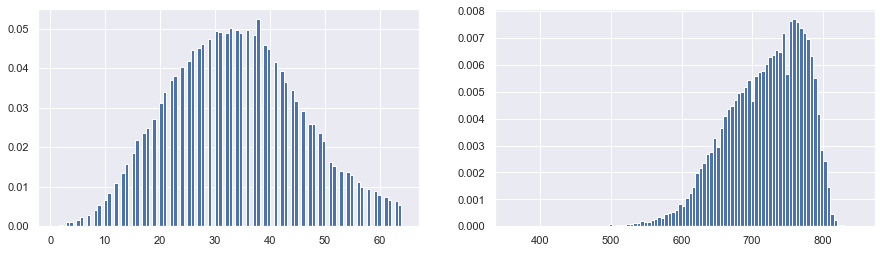

In [270]:
# impulate missing value of 'DTI' and 'CREDIT_SCORE'
import seaborn as sns
sns.set()
fig=plt.figure(figsize=(15,4))
ax1=fig.add_subplot(121)
A2e['DTI'].hist(bins=100,density=1)
ax2=fig.add_subplot(122)
A2e['CREDIT_SCORE'].hist(bins=100,density=1)

In [271]:
# normal distributed, suitable for mean impulation
A2e['DTI']=A2e['DTI'].fillna(A2e['DTI'].mean())

#skewed distributed, suitible for median imputation
A2e['CREDIT_SCORE']=A2e['CREDIT_SCORE'].fillna(A2e['CREDIT_SCORE'].median())

C:\Users\ROXHO\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\ROXHO\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [272]:
#NANnum=[A0e.iloc[:,i].isna().sum() for i in range(32)]
#NANnum=pd.DataFrame({'Feature Name':A0e.columns,"NAN number":NANnum})
#NANnum

In [273]:
# drop columns'FIRST_TIME_IND'and'CO_CREDIT_SCORE'and'MORT_INS_TYPE'

In [274]:
A2f=A2e.drop(['MORT_INS_PCT'],axis=1)
A2g=A2f.drop(['CO_CREDIT_SCORE'],axis=1)
A2h=A2g.drop(['MORT_INS_TYPE'],axis=1)

In [275]:
A2h.shape

(156351, 22)

In [276]:
A2h.head()

,OCHANNEL,SELLER,INT_RATE,UPB,TERM,ORIG_DATE,FIRST_PMT_DATE,LTV,CLTV,NBORROWERS,...,FIRST_TIME_IND,LOAN_PURPOSE,PROPERTY_TYPE,NUNITS,OCC_STATUS,STATE,ZIP,PROD_TYPE,REL_MORT_IND,group
LID,,,,,,,,,,,,,,,,,,,,,
899993094470,C,"FLAGSTAR BANK, FSB",7.875,99000.0,360.0,2000-12-01,2001-02-01,80.0,80.0,1.0,...,N,C,SF,1,P,CA,923,FRM,N,2
899984345565,B,"FLAGSTAR BANK, FSB",7.625,102000.0,360.0,2001-03-01,2001-05-01,80.0,80.0,2.0,...,N,C,SF,1,P,WI,541,FRM,N,2
899962467067,R,"BANK OF AMERICA, N.A.",7.750,228000.0,360.0,2000-12-01,2001-02-01,95.0,95.0,2.0,...,N,P,SF,1,P,AL,352,FRM,N,2
899956562768,R,"JPMORGAN CHASE BANK, NA",6.875,275000.0,240.0,2000-12-01,2001-02-01,71.0,71.0,1.0,...,N,P,PU,1,P,VA,201,FRM,N,2
899955704832,C,"BANK OF AMERICA, N.A.",7.125,160000.0,360.0,2000-12-01,2001-02-01,80.0,80.0,1.0,...,N,P,CO,1,P,HI,968,FRM,N,2


In [277]:
NANnum=[A2h.iloc[:,i].isna().sum() for i in range(22)]
NANnum=pd.DataFrame({'Feature Name':A2h.columns,"NAN number":NANnum})
NANnum
# Now there are no missing values in dataframe

,Feature Name,NAN number
0,OCHANNEL,0
1,SELLER,0
2,INT_RATE,0
3,UPB,0
4,TERM,0
5,ORIG_DATE,0
6,FIRST_PMT_DATE,0
7,LTV,0
8,CLTV,0
9,NBORROWERS,0


## 2) Preliminary Feature Selection

### a. Remove feature with zero variance

In [278]:
#Get all value of 'PROD_TYPE'
A2h['PROD_TYPE'].unique()

array(['FRM'], dtype=object)

In [279]:
#'PROD_TYPE'only has one value, so we drop this variable
A2i=A2h.drop(['PROD_TYPE'],axis=1)

### b.Drop useless columns

In [280]:
#Drop 'ORIG_DATE','FIRST_PMT_DATE','SELLER','ZIP','STATE' ,'OCHANNEL'and'group
A2j=A2i.drop(['ORIG_DATE'],axis=1)
A2j=A2j.drop(['FIRST_PMT_DATE'],axis=1)
A2j=A2j.drop(['SELLER'],axis=1)
A2j=A2j.drop(['ZIP'],axis=1)
A2j=A2j.drop(['STATE'],axis=1)
A2j=A2j.drop(['OCHANNEL'],axis=1)
A2j=A2j.drop(['group'],axis=1)

In [281]:
A2j.shape

(156351, 14)

## 3) Dummy Variables

### a.Get value of each character variable

In [282]:
A2j['FIRST_TIME_IND'].unique()

array(['N', 'Y', 'U'], dtype=object)

In [283]:
A2j['LOAN_PURPOSE'].unique()

array(['C', 'P', 'R', 'U'], dtype=object)

In [284]:
A2j['PROPERTY_TYPE'].unique()

array(['SF', 'PU', 'CO', 'MH', 'CP'], dtype=object)

In [285]:
A2j['NUNITS'].unique()

array([1, 3, 2, 4], dtype=int64)

In [286]:
A2j['OCC_STATUS'].unique()

array(['P', 'S', 'I'], dtype=object)

In [287]:
A2j['REL_MORT_IND'].unique()

array(['N', 'Y'], dtype=object)

### b. Get dummies

In [288]:
#Get dummies of each character variable and change their columns names
FIRST_TIME_IND_dummy=pd.get_dummies(A2j["FIRST_TIME_IND"],drop_first=True)
FIRST_TIME_IND_dummy.columns=['FTI(U)','FTI(Y)']

LOAN_PURPOSE_dummy=pd.get_dummies(A2j["LOAN_PURPOSE"],drop_first=True)
LOAN_PURPOSE_dummy.columns=['LP(P)','LP(R)','LP(U)']

PROPERTY_TYPE_dummy=pd.get_dummies(A2j["PROPERTY_TYPE"],drop_first=True)
PROPERTY_TYPE_dummy.columns=['PT(CP)','PT(MH)','PT(PU)','PT(SF)']

NUNITS_dummy=pd.get_dummies(A2j["NUNITS"],drop_first=True)
NUNITS_dummy.columns=['NUNITS(2)','NUNUTS(3)','NUNUTS(4)']

OCC_STATUS_dummy=pd.get_dummies(A2j["OCC_STATUS"],drop_first=True)
OCC_STATUS_dummy.columns=['OCC(P)','OCC(S)']

REL_MORT_IND_dummy=pd.get_dummies(A2j["REL_MORT_IND"],drop_first=True)
REL_MORT_IND_dummy.columns=['RMI(Y)']

In [289]:
#Merge dummies to original dataframe
A2k=A2j.merge(FIRST_TIME_IND_dummy,how='inner',left_on='LID',right_on='LID')
A2l=A2k.merge(LOAN_PURPOSE_dummy,how='inner',left_on='LID',right_on='LID')
A2m=A2l.merge(PROPERTY_TYPE_dummy,how='inner',left_on='LID',right_on='LID')
A2n=A2m.merge(NUNITS_dummy,how='inner',left_on='LID',right_on='LID')
A2o=A2n.merge(OCC_STATUS_dummy,how='inner',left_on='LID',right_on='LID')
A2p=A2o.merge(REL_MORT_IND_dummy,how='inner',left_on='LID',right_on='LID')

In [290]:
#Drop original columns of character variables
A2p=A2p.drop(['FIRST_TIME_IND'],axis=1)
A2p=A2p.drop(['LOAN_PURPOSE'],axis=1)
A2p=A2p.drop(['PROPERTY_TYPE'],axis=1)
A2p=A2p.drop(['NUNITS'],axis=1)
A2p=A2p.drop(['OCC_STATUS'],axis=1)
A2p=A2p.drop(['REL_MORT_IND'],axis=1)

In [291]:
A2p.shape

(156351, 23)

## 2) Predict p(12),p(24),p(36),p(48),p(60); r(12),r(24),r(36),r(48),r(60)for A2

### a. predict p and r

In [292]:
# Predict p
p12=clfT_1.predict_proba(A2p)[:,1]
p24=clfT_2.predict_proba(A2p)[:,1]
p36=clfT_3.predict_proba(A2p)[:,1]
p48=clfT_4.predict_proba(A2p)[:,1]
p60=clfT_5.predict_proba(A2p)[:,1]

In [296]:
#predict r
r12=regLR_1.predict(A2p)
r24=regLR_2.predict(A2p)
r36=regLR_3.predict(A2p)
r48=regLR_4.predict(A2p)
r60=regLR_5.predict(A2p)

### b. combine r(12),r(24),r(36),r(48),r(60) and p(12),p(24),p(36),p(48),p(60) into a single dataframe

In [299]:
PredictionA2=pd.DataFrame({"LID": A2p.index, "p_12":p12, "p_24":p24, "p_36": p36, "p_48":p48, "p_60":p60, "r_12":r12,"r_24":r12, "r_36":r12, "r_48":r12, "r_60":r12})

### c. Save as predictions

In [300]:
PredictionA2.to_csv("predictions.csv")